## Reversionspendel

In [2]:
%pylab qt5
import os

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (11, 7)

import scipy.optimize

numpy.set_printoptions(linewidth=100)

Populating the interactive namespace from numpy and matplotlib


In [109]:
# lade Daten
A = loadtxt('./versuch1.csv', delimiter=',', skiprows=1,
           converters=dict(zip([2, 4], [lambda s: NaN if s==b'' else float(s)]*2)))
n, T1, dev_T1, T2, dev_T2 = transpose(A)

In [110]:
# schätzt Standardabweichung ab und berücksichtig mehrfachmessungen
mult = [[2.241, 2.250, 2.258, 2.258], [1.908, 1.923], [1.805, 1.806, 1.801, 1.804]]
num = 4 + 2 + 4
var = 0
for l in mult:
    l = array(l)
    m = mean(l)
    q = (l - m)/m
    print(q)
    var += sum(q**2)/sqrt(num-1)
devq = sqrt(var)
devq, devq * 1.8

[-0.00477406 -0.00077717  0.00277562  0.00277562]
[-0.00391543  0.00391543]
[ 0.00055432  0.00110865 -0.00166297  0.        ]


(0.004958722732849593, 0.008925700919129267)

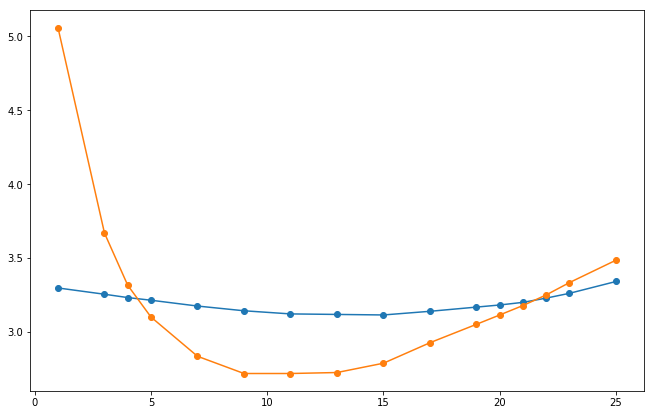

In [111]:
plt.plot(n, transpose([T1**2, T2**2]), 'o-')

In [112]:
def fun3(x, a, b, c, x0):
    return (a + b * (x - x0)**2) / (x - x0 + c)

def jac3(x, a, b, c, x0):
    return transpose([1/(c + x - x0),
                  ((x - x0)**2/(c + x - x0)),
                  -(a + b*(x - x0)**2)/(c + x - x0)**2,
                  -b + (a + b*c**2)/(c + x - x0)**2])

def dx(x, a, b, c, x0):
    return b - (a + b*c**2)/(x - x0 + c)**2

In [113]:
# wird jetzt doch nicht mehr gebraucht, nachdem ich sinnvolle Startwerde für p1 gefunden habe...
# aber ich lass das mal drin weil die Methode mal anders vielleicht praktisch sein könnte
def fit_curve(f, x, y, p0=None, maxfev=3000, fixed=None, jac=None, **kwargs):
    nargs = f.__code__.co_argcount - 1
    if fixed == None:
        fixed = [None]*nargs
    if p0 == None:
        p0 = [1]*nargs
    assert len(fixed) == len(p0) == nargs, (nargs, fixed, p0)
    p0it = iter(p0)
    p0_ = array([p0[i] for i in range(nargs) if fixed[i] is None])
    
    ff = lambda *args: f(*(arg for i, arg in enumerate(args) if i==0 or not fixed[i-1]))
    def ff(*args):
        it = iter(args)
        return f(next(it), *(next(it) if val is None else val for val in fixed))
    
    def jac_(*args):
        it = iter(args)
        grad = jac(next(it), *(next(it) if val is None else val for val in fixed))
        return array([[rad[i] for i in range(nargs) if fixed[i] is None]])
    
    popt, pcov = scipy.optimize.curve_fit(ff, x, y, p0=p0_, maxfev=maxfev, **kwargs)
    pit = iter(popt)
    return array([next(pit) if val is None else val for val in fixed]), pcov

Wir fitten nun unsere Theoriekurve in die Daten. Es ist sehr wichtig dabei gute startparameter zu wählen. Insbesondere müssen `a` und `b` das korrekte Vorzeichen haben (erschließt sich aus der Geometrie des Pendels). Auserdem muss die Differenz `x0 - c` auf der richtigen Seite des Intervalls $[1, 25]$ (und auf keinen Fall innerhalb) liegen.

[-160.46691   -0.08527  -42.32315   31.94507]
[[1.12e+03 4.44e-01 4.07e+02 9.93e+01]
 [4.44e-01 1.78e-04 1.62e-01 3.97e-02]
 [4.07e+02 1.62e-01 1.48e+02 3.61e+01]
 [9.93e+01 3.97e-02 3.61e+01 8.88e+00]]

[18.86005  0.10435  0.52257 -2.45269]
[[4.12e-01 1.19e-03 2.37e-01 1.76e-01]
 [1.19e-03 3.91e-06 7.24e-04 5.55e-04]
 [2.37e-01 7.24e-04 1.40e-01 1.05e-01]
 [1.76e-01 5.55e-04 1.05e-01 8.02e-02]]


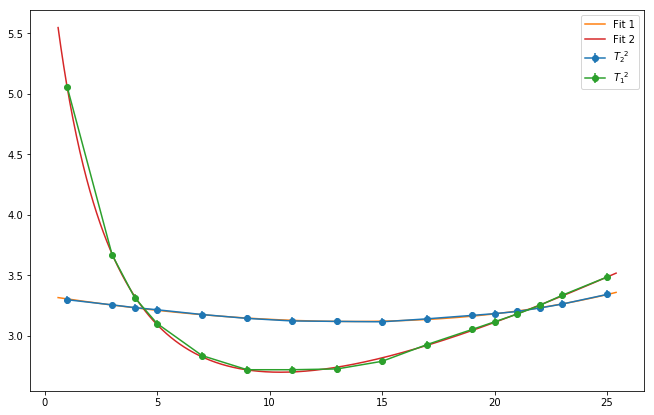

In [114]:
fit = fun3
sc = 1 # damit überprüfen wir ob die Numerik passt

p01=array([sc*-160, sc*-0.085, -42, 32])
p02 = [18, 0.1, .5, -2.5]

mess1 = array([1, 1/sqrt(4)] + [1]*14) # berücksichtigt mehrfachmessungen
popt1, pcov1 = scipy.optimize.curve_fit(fit, n, sc*T1**2, p0=p01, sigma=2*T1**2*devq*mess1,
                                        jac=jac3, maxfev=3000)

print(array_str(popt1, precision=5, suppress_small=True))
print(array_str(pcov1, precision=2))
print()

x = linspace(min(n) - .4, max(n) + .4, 1000)
_ = plt.errorbar(n, sc*T1**2, yerr=2*T1**2*devq*mess1, fmt='o-')
_ = plt.plot(x, vectorize(fit)(x, *popt1))


mess2 = array([1/sqrt(4), 1/sqrt(2)] + [1]*14) # berücksichtigt mehrfachmessungen
popt2, pcov2 = scipy.optimize.curve_fit(fit, n, T2**2, p0=p02, sigma=2*T2**2*devq*mess2, jac=jac3)

print(array_str(popt2, precision=5, suppress_small=True))
print(array_str(pcov2, precision=2))

_ = plt.errorbar(n, T2**2, yerr=2*T1**2*devq*mess2, fmt='o-')
_ = plt.plot(x, vectorize(fit)(x, *popt2))

plt.legend(['Fit 1', 'Fit 2', '${T_2}^2$', '${T_1}^2$'])

Die Konditionen der involvierten Matrizen sind zwar alles andere als optimal, aber `scipy.optimize.curve_fit` scheint nur mit `float64` zu arbeiten

In [115]:
cond(pcov1)
cond(pcov2)

79753852866.25223

15455722.31701843

In [116]:
savetxt('werte1.csv', transpose([n, T1, T1*devq*mess1, T2, T2*devq*mess2]),
        header='n,T1,err_T1,T2,err_T2', comments='',  delimiter=',')

Wir Berechnen die Schnittpunkte der beiden Graphen numerisch (Newton-Verfahren)

In [117]:
z1 = scipy.optimize.newton(lambda x: fun3(x, *popt1) - fun3(x, *popt2), 4.4, fprime=lambda x: dx(x, *popt1) - dx(x, *popt2))
z2 = scipy.optimize.newton(lambda x: fun3(x, *popt1) - fun3(x, *popt2), 21.5, fprime=lambda x: dx(x, *popt1) - dx(x, *popt2))
print(z1, z2)

4.395324043697864 21.513234821502838


$y = T^2$ 

In [118]:
y1 = fun3(z1, *popt1)
y2 = fun3(z2, *popt1)
sqrt(y1), sqrt(y2)
print(y1, y2, y1 - y2)

(1.7952022106550012, 1.7937743845681187)

3.2227509771406035 3.2176265427327326 0.005124434407870915


In [119]:
def grad1y(x, popt1, popt2):
    return -jac3(x, *popt1) * dx(x, *popt2) / (dx(x, *popt1) - dx(x, *popt2))

def grad2y(x, popt1, popt2):
    return -jac3(x, *popt2) * dx(x, *popt1) / (dx(x, *popt2) - dx(x, *popt1))

In [120]:
grad1y(z1, popt1, popt2)
grad2y(z1, popt1, popt2)

grad1y(z2, popt1, popt2)
grad2y(z2, popt1, popt2)

array([ -0.01567154, -11.89451368,   0.05050546,   0.02312134])

array([-0.01289119, -0.60453696,  0.0415451 , -0.02312134])

array([-0.03029634, -3.29694226,  0.09748229, -0.04358617])

array([ -0.02443118, -14.03243068,   0.0786104 ,   0.04358617])

Wir können überprüfen, ob die Gradienten stimmen, indem wir die Parametervektoren perturbieren und nachprüfen, dass die Differenz der neuen y-Werte zu den Alten fast gleich den Produkt des Gradienten und der Perturbation ist.

In [121]:
dp1 = [0, 0, 0.01, 0]
dp2 = [0, 0, 0, 0]
p1 = popt1 + dp1
p2 = popt2 + dp2
res = fun3(scipy.optimize.newton(lambda x: fun3(x, *p1) - fun3(x, *p2), 4.4, fprime=lambda x: dx(x, *p1) - dx(x, *p2)), *p1)
print(res)
print(res - y1)
print(res - y1 - grad1y(z1, popt1, popt2) @ dp1 - grad2y(z1, popt1, popt2) @ dp2) # sollte viel kleiner als störung sein

3.223256080906203
0.000505103765599646
4.9184798355558605e-08


In [122]:
var_y1 = grad1y(z1, popt1, popt2) @ pcov1 @ grad1y(z1, popt1, popt2) + \
         grad2y(z1, popt1, popt2) @ pcov2 @ grad2y(z1, popt1, popt2)

# grad1y(z1, popt1, popt2) @ pcov1 @ grad1y(z1, popt1, popt2)
# grad2y(z1, popt1, popt2) @ pcov2 @ grad2y(z1, popt1, popt2)

var_y2 = grad1y(z2, popt1, popt2) @ pcov1 @ grad1y(z2, popt1, popt2) + \
         grad2y(z2, popt1, popt2) @ pcov2 @ grad2y(z2, popt1, popt2)

print(sqrt(var_z1), sqrt(var_z2))
cov_y = grad1y(z1, popt1, popt2) @ pcov1 @ grad1y(z2, popt1, popt2) + \
        grad2y(z1, popt1, popt2) @ pcov2 @ grad2y(z2, popt1, popt2)
print()
COV = array([[var_y1, cov_y], [cov_y, var_y2]])
print(COV)
assert all(eigvals(COV) > 0) # Kovarianzmatrix sollte positiv definit sein

0.0017628683607662278 0.004443260073176469

[[ 3.10770486e-06 -1.01549730e-06]
 [-1.01549730e-06  1.97425601e-05]]


In [123]:
A = inv(COV)
w1 = (A[0, 0] + A[0, 1]) / (sum(A, (0, 1)))
w2 = (A[1, 0] + A[1, 1]) / (sum(A, (0, 1)))
print(w1, w2)
y = w1*y1 + w2*y2
var_y = [w1, w2] @ COV @ [w1, w2]
err_y = sqrt(var_y)
print(f'{y} +- {err_y}')

0.8342848298226888 0.1657151701773113
3.2219017806206414 +- 0.0015570573882257319


In [143]:
l = 0.800
err_l = 0.0005

T = sqrt(y)
err_T = .5/T * err_y

g = 4 * pi**2 * l / y
e1 = 4 * pi**2 * l / y**2 * err_y
e2 = 4 * pi**2 / y * err_l
e1, e2
err_g = sqrt(e1**2 + e2**2 +  (g * 2*0.25e-3 / 1.75)**2 + (g * .5 * (pi/180)**2)**2)
print(f'{g:.6} +- {err_g:.3}')

(0.004737287579294128, 0.006126570623880507)

9.80251 +- 0.00837


In [134]:
err_y / y

0.00048327276690780834

In [137]:
g * .5 * (pi/180)**2

0.0014930081084700202